In [1]:
import pandas as pd
from PIL import Image
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score

In [2]:
import time
start_time = time.time()

In [3]:
images_path = '../images'
population_data_path = '../data/full_data.csv'

In [4]:
def crop_and_resize(image: Image.Image, size: int) -> Image.Image:
    """
    Crop a PIL image to a square by trimming the longer side and centering,
    then resize it to the designated resolution.
    
    :param image: Input PIL Image
    :param size: Target resolution (size x size)
    :return: Processed PIL Image
    """
    width, height = image.size
    min_side = min(width, height)
    
    # Calculate crop box for center cropping
    left = (width - min_side) // 2
    top = (height - min_side) // 2
    right = left + min_side
    bottom = top + min_side
    
    # Crop to square
    cropped_image = image.crop((left, top, right, bottom))
    
    # Resize to designated resolution
    resized_image = cropped_image.resize((size, size), Image.LANCZOS)
    
    return resized_image

In [5]:
images = {}

for dir in os.listdir(images_path)[:]:
    if not dir.endswith('.png'):
        continue
    
    full_path = f'{images_path}/{dir}'
    image = Image.open(full_path)
    square_image = crop_and_resize(image, 128)
    images[dir[:-4].lower()] = square_image
    
print(f'Loaded {len(images)} images')
images

Loaded 944 images


{'rio_de_janeiro': <PIL.Image.Image image mode=RGB size=128x128>,
 'sao_luis': <PIL.Image.Image image mode=RGB size=128x128>,
 'arequipa': <PIL.Image.Image image mode=RGB size=128x128>,
 'posadas': <PIL.Image.Image image mode=RGB size=128x128>,
 'zaragoza': <PIL.Image.Image image mode=RGB size=128x128>,
 "xi'an": <PIL.Image.Image image mode=RGB size=128x128>,
 'hrodna': <PIL.Image.Image image mode=RGB size=128x128>,
 'guadalajara': <PIL.Image.Image image mode=RGB size=128x128>,
 'bogor': <PIL.Image.Image image mode=RGB size=128x128>,
 'tegucigalpa': <PIL.Image.Image image mode=RGB size=128x128>,
 'siem_reap': <PIL.Image.Image image mode=RGB size=128x128>,
 'weinan': <PIL.Image.Image image mode=RGB size=128x128>,
 'al_hasakah': <PIL.Image.Image image mode=RGB size=128x128>,
 'stockholm': <PIL.Image.Image image mode=RGB size=128x128>,
 'quito': <PIL.Image.Image image mode=RGB size=128x128>,
 'surat': <PIL.Image.Image image mode=RGB size=128x128>,
 'madrid': <PIL.Image.Image image mode=RG

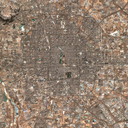

In [6]:
images['beijing']

In [7]:
images_df = pd.DataFrame.from_dict(images, orient='index', columns=['image'])
images_df = images_df.reset_index().rename(columns={'index': 'name'})
images_df

,name,image
0,rio_de_janeiro,<PIL.Image.Image image mode=RGB size=128x128 a...
1,sao_luis,<PIL.Image.Image image mode=RGB size=128x128 a...
2,arequipa,<PIL.Image.Image image mode=RGB size=128x128 a...
3,posadas,<PIL.Image.Image image mode=RGB size=128x128 a...
4,zaragoza,<PIL.Image.Image image mode=RGB size=128x128 a...
...,...,...
939,changsha,<PIL.Image.Image image mode=RGB size=128x128 a...
940,monterrey,<PIL.Image.Image image mode=RGB size=128x128 a...
941,guntur,<PIL.Image.Image image mode=RGB size=128x128 a...
942,kyiv,<PIL.Image.Image image mode=RGB size=128x128 a...


In [8]:
population = pd.read_csv(population_data_path)
population['name'] = population['name'].str.lower().str.replace(' ', '_')

n_classes = 5
population['city_class'], bins = pd.qcut(population['population'], q=n_classes, labels=False, retbins=True)
print("Population thresholds for each class:")
for i in range(len(bins)-1):
    print(f"Class {i}: {bins[i]:,.0f} - {bins[i+1]:,.0f} people")
population

Population thresholds for each class:
Class 0: 5,170 - 175,033 people
Class 1: 175,033 - 510,509 people
Class 2: 510,509 - 1,073,747 people
Class 3: 1,073,747 - 2,874,330 people
Class 4: 2,874,330 - 37,977,000 people


,name,lon,lat,population,city_class
0,shanghai,121.4670,31.1667,22120000,4
1,beijing,116.3910,39.9050,19433000,4
2,shenzhen,114.0540,22.5350,15929000,4
3,guangzhou,113.2590,23.1288,20902000,4
4,chengdu,104.0670,30.6636,11309000,4
...,...,...,...,...,...
959,zadar,15.2167,44.1167,75082,0
960,nampula,39.2667,-15.1167,477900,1
961,slavonski_brod,18.0144,45.1553,56769,0
962,karlovac,15.5558,45.4931,53134,0


In [9]:
df = pd.merge(population, images_df, on='name', how='left')
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,name,lon,lat,population,city_class,image
0,shanghai,121.4670,31.1667,22120000,4,<PIL.Image.Image image mode=RGB size=128x128 a...
1,beijing,116.3910,39.9050,19433000,4,<PIL.Image.Image image mode=RGB size=128x128 a...
2,shenzhen,114.0540,22.5350,15929000,4,<PIL.Image.Image image mode=RGB size=128x128 a...
3,guangzhou,113.2590,23.1288,20902000,4,<PIL.Image.Image image mode=RGB size=128x128 a...
4,chengdu,104.0670,30.6636,11309000,4,<PIL.Image.Image image mode=RGB size=128x128 a...
...,...,...,...,...,...,...
959,zadar,15.2167,44.1167,75082,0,<PIL.Image.Image image mode=RGB size=128x128 a...
960,nampula,39.2667,-15.1167,477900,1,<PIL.Image.Image image mode=RGB size=128x128 a...
961,slavonski_brod,18.0144,45.1553,56769,0,<PIL.Image.Image image mode=RGB size=128x128 a...
962,karlovac,15.5558,45.4931,53134,0,<PIL.Image.Image image mode=RGB size=128x128 a...


In [10]:
class PILImageListValueDataset(Dataset):
    """
    Dataset class to load a list of PIL images and a corresponding list of values.
    """
    def __init__(self, image_list, target_values, transform=None):
        """
        Args:
            image_list (list): A list of PIL Image objects.
            target_values (list): A list of target values corresponding to each image.
                                  Ensure the length matches the image_list.
            transform (callable, optional): Optional transform to be applied
                on the image. Defaults to None.
        """
        if len(image_list) != len(target_values):
            raise ValueError("The length of image_list and target_values must be the same.")

        self.image_list = image_list
        self.target_values = target_values
        self.transform = transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image = self.image_list[idx]
        target_value = self.target_values[idx]

        if torch.rand(1) < 0.5:
            image = image.rotate(90)

        if torch.rand(1) < 0.5:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)

        if torch.rand(1) < 0.5:
            image = image.transpose(Image.FLIP_TOP_BOTTOM)

        if self.transform:
            image = self.transform(image)

        # Convert target_value to a PyTorch Tensor if it's not already
        if not isinstance(target_value, torch.Tensor):
            target_value = torch.tensor(target_value).float()  # Adjust dtype as needed

        return image, target_value 

In [11]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = PILImageListValueDataset(df['image'], torch.tensor(df['city_class'].tolist()), data_transform)
ratio = 0.8
train_len = int(len(dataset) * ratio)
test_len = len(dataset) - train_len
train_dataset, test_dataset = random_split(dataset, [train_len, test_len])
# Get indices for each class
class_indices = {i: [] for i in range(5)}
for idx in range(len(test_dataset)):
    _, label = test_dataset[idx]
    class_indices[int(label)].append(idx)

for i in range(5):
    print(len(class_indices[i]))

train_loader = DataLoader(
    train_dataset,
    32,
    True
)

len(train_dataset)

42
47
38
32
34


771

In [12]:
model = nn.Sequential(
    nn.Conv2d(3, 32, 3, 1, 'same'),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Dropout(0.1),
    nn.Conv2d(32, 64, 3, 1, 'same'),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Dropout(0.1),
    nn.Conv2d(64, 128, 3, 1, 'same'),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),

    nn.Dropout(0.1),
    nn.Conv2d(128, 128, 3, 1, 'same'),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Dropout(0.1),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 8),
    nn.ReLU(),
    nn.Linear(8, 5)
)

y_loss = []
optim = torch.optim.Adam(model.parameters(), 1e-3)
criterion = nn.CrossEntropyLoss()

In [36]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(dev)
model.train()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.1, inplace=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Dropout(p=0.1, inplace=False)
  (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (16): BatchNorm2d(128, eps=1e-05,

In [37]:
epoch_n = 512

for epoch in range(epoch_n):
    # Set the model to training mode
    model.train()
    epoch_loss = 0.0
    num_batches = 0

    # Iterate over the batches in the DataLoader
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move the input and target tensors to the device (e.g., GPU if available)
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            targets = targets.cuda()
        
        # Forward pass
        predictions = model(inputs)

        # Calculate the loss
        loss = criterion(predictions, targets)

        # Backward pass and optimization
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Record the loss for this batch
        epoch_loss += loss.item()
        num_batches += 1

        # Optional: Print batch-level loss
        # if batch_idx % 100 == 0:
        #     print(f"Epoch [{epoch+1}/{epoch_n}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate the average loss for the epoch
    avg_epoch_loss = epoch_loss / num_batches
    y_loss.append(avg_epoch_loss)

    # Print the average loss for the epoch
    print(f"Epoch [{epoch+1}/{epoch_n}], Average Loss: {avg_epoch_loss:.4f}")

Epoch [1/512], Average Loss: 0.2095
Epoch [2/512], Average Loss: 0.1496
Epoch [3/512], Average Loss: 0.1438
Epoch [4/512], Average Loss: 0.2549
Epoch [5/512], Average Loss: 0.1179
Epoch [6/512], Average Loss: 0.1757
Epoch [7/512], Average Loss: 0.1874
Epoch [8/512], Average Loss: 0.1767
Epoch [9/512], Average Loss: 0.2546
Epoch [10/512], Average Loss: 0.2533
Epoch [11/512], Average Loss: 0.1938
Epoch [12/512], Average Loss: 0.1666
Epoch [13/512], Average Loss: 0.1435
Epoch [14/512], Average Loss: 0.1139
Epoch [15/512], Average Loss: 0.1426
Epoch [16/512], Average Loss: 0.1797
Epoch [17/512], Average Loss: 0.1867
Epoch [18/512], Average Loss: 0.1229
Epoch [19/512], Average Loss: 0.0998
Epoch [20/512], Average Loss: 0.1267
Epoch [21/512], Average Loss: 0.2420
Epoch [22/512], Average Loss: 0.2007
Epoch [23/512], Average Loss: 0.2496
Epoch [24/512], Average Loss: 0.2590
Epoch [25/512], Average Loss: 0.2288
Epoch [26/512], Average Loss: 0.1731
Epoch [27/512], Average Loss: 0.1307
Epoch [28/

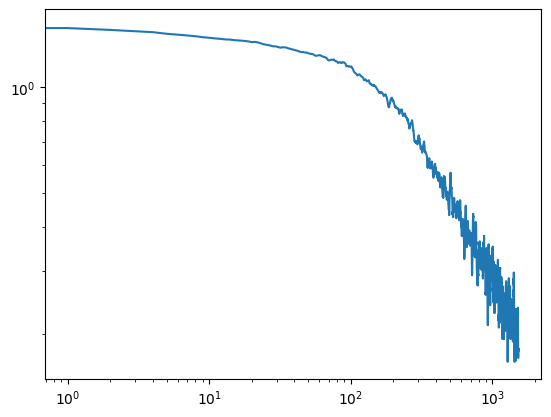

In [31]:
plt.plot(np.convolve(y_loss, np.ones(10)/10, mode='valid'))
plt.yscale('log')
plt.xscale('log')

In [32]:
model.eval()

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Dropout(p=0.1, inplace=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Dropout(p=0.1, inplace=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Dropout(p=0.1, inplace=False)
  (15): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (16): BatchNorm2d(128, eps=1e-05,

In [33]:
model.to('cpu')
a = 0

for (img, population) in train_dataset:
    prediction = model(img.unsqueeze(0))
    a += (torch.argmax(prediction) == population).sum()
    
a = a.item() / len(train_dataset)
print(a)


0.6627756160830091


In [34]:
model.to('cpu')
a = 0

targets = []
predictions = []

for (img, population) in test_dataset:
    prediction = model(img.unsqueeze(0))
    a += (torch.argmax(prediction) == population).sum()
    targets.append(population.item())
    predictions.append(torch.argmax(prediction).item())
    
a = a.item() / len(test_dataset)
print(a)

0.30569948186528495


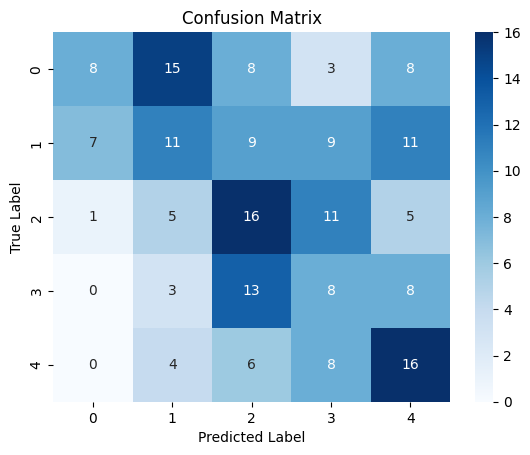


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.19      0.28        42
           1       0.29      0.23      0.26        47
           2       0.31      0.42      0.36        38
           3       0.21      0.25      0.23        32
           4       0.33      0.47      0.39        34

    accuracy                           0.31       193
   macro avg       0.33      0.31      0.30       193
weighted avg       0.33      0.31      0.30       193



In [35]:
matrix = confusion_matrix(targets, predictions)

# Plot confusion matrix
plt.figure(dpi=100)
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate metrics
print("\nClassification Report:")
print(classification_report(targets, predictions))
